In [1]:
"""
# load the tensorboard notebook extension
%load_ext tensorboard
"""

'\n# load the tensorboard notebook extension\n%load_ext tensorboard\n'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf
import datetime

# clear any logs from previous runs
!rm -rf ./logs/

from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [3]:
import os

In [4]:
train_dir = '../Flag_Data/train'
val_dir = '../Flag_Data/val'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

batch_size = 64

# train dataset 불러오기
trainGen = imageGenerator.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    subset='training',
    class_mode='categorical'
)

# val dataset 불러오기
validationGen = imageGenerator.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    subset='validation',
    class_mode='categorical'
)

Found 2425 images belonging to 7 classes.
Found 33 images belonging to 7 classes.


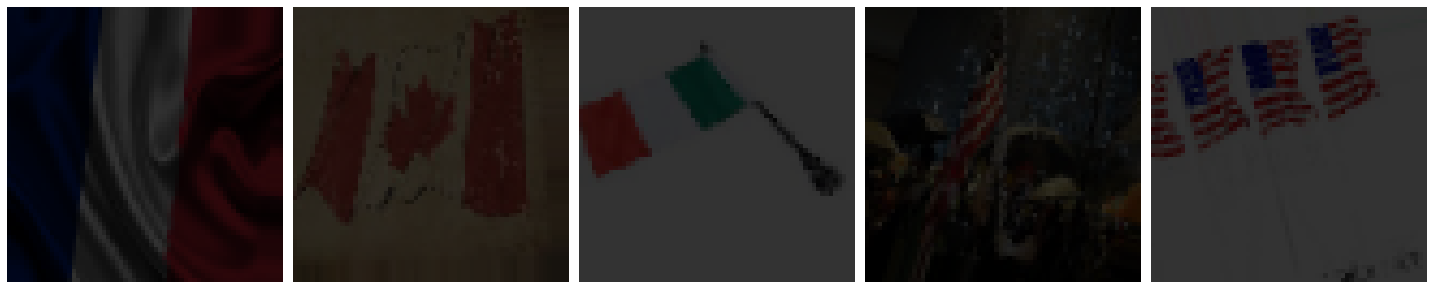

In [6]:
#옮겨 담기
sample_training_images, _ = next(trainGen)

# 이미지를 보여주는 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

In [7]:
# import tensorflow.keras modules

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import AveragePooling2D

In [8]:
def inception_Generator(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', 
                      activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', 
                      activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', 
                      activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', 
                      activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', 
                      activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', 
                       activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [9]:
# Neural network immitating GoogLeNet

inputs = Input(shape=(64,64,3))

x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
x = MaxPool2D((3,3), strides=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)

x = inception_Generator(x,
                       filters_1x1=32,
                       filters_3x3_reduce=64,
                       filters_3x3=128,
                       filters_5x5_reduce=16,
                       filters_5x5=32,
                       filters_pool_proj=32,
                       name='inception_3a')

x = inception_Generator(x,
                       filters_1x1=128,
                       filters_3x3_reduce=32,
                       filters_3x3=128,
                       filters_5x5_reduce=16,
                       filters_5x5=48,
                       filters_pool_proj=64,
                       name='inception_3b')

x = AveragePooling2D((5,5), strides=3)(x)

x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax', name='output')(x)

model_googLeNet = Model(inputs=inputs, outputs=x)
model_googLeNet.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_googLeNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 32)   544         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [10]:
epochs = 5

model_googLeNet.fit((item for item in trainGen), 
          epochs=5, 
          steps_per_epoch=trainGen.samples / epochs,
                    validation_data = (item for item in validationGen), 
          validation_steps =validationGen.samples/epochs)

model_googLeNet.save('googLeNet_20200604.h5')

Epoch 1/5
485/485 [==============================] - 147s 303ms/step - loss: 0.8867 - accuracy: 0.6735 - val_loss: 0.8570 - val_accuracy: 0.7023
Epoch 2/5
485/485 [==============================] - 151s 311ms/step - loss: 0.3520 - accuracy: 0.8866 - val_loss: 0.7986 - val_accuracy: 0.8015
Epoch 3/5
485/485 [==============================] - 149s 308ms/step - loss: 0.2217 - accuracy: 0.9322 - val_loss: 0.4693 - val_accuracy: 0.8321
Epoch 4/5
485/485 [==============================] - 150s 308ms/step - loss: 0.1611 - accuracy: 0.9511 - val_loss: 0.4409 - val_accuracy: 0.8473
Epoch 5/5
485/485 [==============================] - 149s 308ms/step - loss: 0.1279 - accuracy: 0.9614 - val_loss: 0.2885 - val_accuracy: 0.9542


In [11]:
from tensorflow.keras.preprocessing.image import array_to_img

country_index = ['can', 'eng','fra','ger','ita','kor','usa']

In [12]:
test_dir = '../Flag_Data/test'

testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
)

# loss and accuracy
model_googLeNet.evaluate(testGen)

Found 199 images belonging to 7 classes.
  38730/Unknown - 3274s 85ms/step - loss: 0.3518 - accuracy: 0.9029

KeyboardInterrupt: 

In [ ]:
imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(country_index[result[0]]))
print('정답: {}'.format(country_index[np.argmax(imgs[1][0])]))

